# MANOVA Test

> Use Case:
- Evaluating the impact of two categorical independent variables (Factors A and B) on a continuous dependent variable.
- Assessing interactions between Factor A and Factor B, as well as their individual effects.

> Assumptions:
1. Normality: The residuals are normally distributed.
2. Homogeneity of Variances: The variances of the residuals are constant across all levels of the factors.
3. Independence: Observations are independent of each other.

> Example Scenario (A/B/C/D Test):
- Factors:
  - Factor A (e.g., Different Versions of a Website)
  - Factor B (e.g., Time of Day)
- Dependent Variable: Continuous metric (e.g., User Engagement)

> Null Hypothesis (H0):
- There is no significant difference in the means of the dependent variable across different levels of Factor A, Factor B, or their interaction.

> Alternative Hypothesis (H1):
- At least one of the means of the dependent variable is different across different levels of Factor A, Factor B, or their interaction.

> Interpretation:
- If the p-value is below the chosen significance level (e.g., 0.05), reject the null hypothesis.
- Significant p-values indicate that there is evidence of a significant difference in means, either due to Factor A, Factor B, or their interaction.

> When to Use:
- When there are two categorical independent variables (Factors A and B) influencing a continuous dependent variable.
- Useful for investigating main effects and interaction effects simultaneously.

In [135]:
import warnings

warnings.filterwarnings("ignore")

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.multivariate.manova import MANOVA

# !pip install scipy==1.12.0
from scipy.stats import normaltest, bartlett, tukey_hsd

# !pip install pingouin==0.5.5
import pingouin as pg

In [137]:
# Set random seed for reproducibility
np.random.seed(42)

In [138]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'yellowgreen'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [139]:
# Set parameters for power analysis
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Number of groups (treatments) in the ANOVA
num_groups = 3

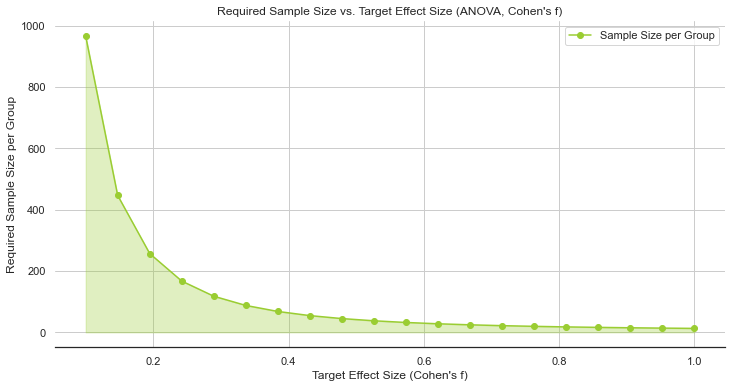

In [140]:
# Define a range of effect sizes to explore
effect_sizes = np.linspace(0.1, 1.0, 20) # From small to large effect sizes

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for effect in effect_sizes:
    # Perform power analysis to calculate sample size
    analysis = FTestAnovaPower()
    n = analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power)
    if n is not None:
        sample_sizes.append(n)
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Target Effect Size (ANOVA, Cohen\'s f)')
plt.xlabel('Target Effect Size (Cohen\'s f)')
plt.ylabel('Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [141]:
# Let's say we anticipate a small effect size (Cohen's f = 0.1)
effect = 0.1

# Perform power analysis to calculate sample size
analysis = FTestAnovaPower()
sample_size_per_group = int(round(analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power), 0))

print(f"Sample size needed per group: {sample_size_per_group}")

Sample size needed per group: 966


### Synthetic Data

In [142]:
# Number of samples per group
n_samples = sample_size_per_group

# Intervention groups (A, B, C)
interventions = np.repeat(['A', 'B', 'C'], n_samples)

# Outcome variables (X1, X2, X3)
X1 = np.concatenate([np.random.normal(10, 5, n_samples),
                    np.random.normal(11, 5, n_samples),
                    np.random.normal(15, 5, n_samples)])

X2 = np.concatenate([np.random.normal(30, 10, n_samples),
                    np.random.normal(29, 10, n_samples),
                    np.random.normal(20, 10, n_samples)])

X3 = np.concatenate([np.random.normal(50, 20, n_samples),
                    np.random.normal(51, 20, n_samples),
                    np.random.normal(58, 20, n_samples)])

# Create a pandas DataFrame
manova_data = pd.DataFrame({'Intervention': interventions, 'CTR': X1, 'Time': X2, 'Spend': X3})

manova_data


,Intervention,CTR,Time,Spend
0,A,12.483571,27.125525,111.965989
1,A,9.308678,32.873289,44.836497
2,A,13.238443,29.544878,60.202487
3,A,17.615149,25.757637,37.012704
4,A,8.829233,24.301671,55.904652
...,...,...,...,...
2893,C,16.076983,-5.065716,60.941537
2894,C,17.541343,22.974621,68.210708
2895,C,34.631189,21.394978,62.034773
2896,C,4.579435,17.151631,68.607384


### Assumptions

In [143]:
# Assumption 1: Multivariate normality (Mardia's test)
mvn_test_result = normaltest(manova_data[['CTR', 'Time', 'Spend']], axis=0)
is_normal = multipletests(mvn_test_result.pvalue, method='bonferroni')[0]

print(f'Multivariate Normality Test Result: {is_normal}')


Multivariate Normality Test Result: [False False False]


In [144]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['CTR'].values, 
                                manova_data[manova_data['Intervention']=='B']['CTR'].values, 
                                manova_data[manova_data['Intervention']=='C']['CTR'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


In [145]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['Time'].values, 
                                manova_data[manova_data['Intervention']=='B']['Time'].values, 
                                manova_data[manova_data['Intervention']=='C']['Time'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


In [146]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['Spend'].values, 
                                manova_data[manova_data['Intervention']=='B']['Spend'].values, 
                                manova_data[manova_data['Intervention']=='C']['Spend'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


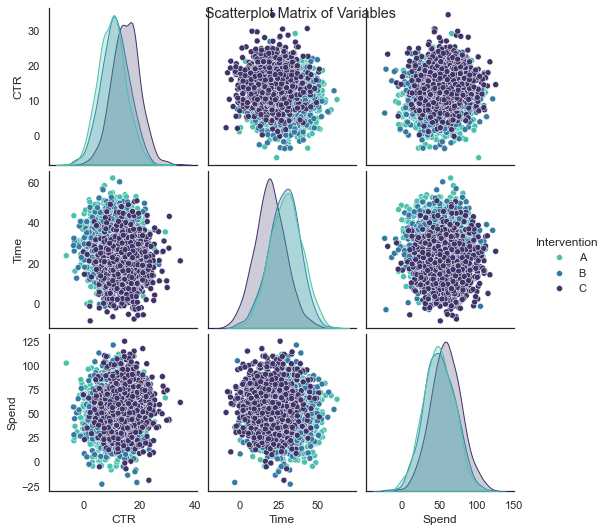

In [147]:
# Plot scatterplot matrix for visual inspection
sns.pairplot(manova_data, hue='Intervention', diag_kind='kde', palette='mako_r')
plt.suptitle('Scatterplot Matrix of Variables')
plt.show()

### MANOVA (statsmodels)

In [148]:
# Fit MANOVA model
manova_model = MANOVA.from_formula('CTR + Time + Spend ~ Intervention', data=manova_data)

# Perform multivariate analysis
result = manova_model.mv_test()

# Display results
print(result)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.1373 3.0000 2893.0000 6057.2893 0.0000
         Pillai's trace 0.8627 3.0000 2893.0000 6057.2893 0.0000
 Hotelling-Lawley trace 6.2813 3.0000 2893.0000 6057.2893 0.0000
    Roy's greatest root 6.2813 3.0000 2893.0000 6057.2893 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
       Intervention      Value  Num DF   Den DF  F Value  Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.7045 6.0000 5786.0000 184.5610 0.0000
          Pillai's trace 0.2958 6.0000 5788.0

> Wilks' Lambda (λ): 
- This is a measure of how much variance in the dependent variables is not accounted for by the independent variables. Smaller values of λ indicate a stronger effect. A p-value associated with Wilks' Lambda tests the null hypothesis that there are no differences among the group means.
> Pillai's Trace (V): 
- Similar to Wilks' Lambda, Pillai's Trace is another measure of the amount of variance explained by the independent variables. Again, a smaller value indicates a stronger effect.
> Hotelling's Trace (T-squared): 
- This is a measure of the overall significance of the multivariate effect. A high T-squared value with a low p-value suggests a significant effect.
> Roy's Largest Root (R): 
- Roy's Largest Root is another statistic used to test the significance of the multivariate effect.

### Post-Hoc (statsmodels)

In [149]:
print("\nPost-Hoc Tests (Univariate ANOVAs with Tukey HSD correction):")

# Perform Post-Hoc tests for each dependent variable
dependent_vars = ['CTR', 'Time', 'Spend']
for var in dependent_vars:
    m_comp = pairwise_tukeyhsd(manova_data[var], manova_data['Intervention'], alpha=0.05)
    print(f"\nPost-Hoc for {var}:")
    print(m_comp)


Post-Hoc Tests (Univariate ANOVAs with Tukey HSD correction):

Post-Hoc for CTR:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     A      B   1.1366 0.001 0.6095 1.6636   True
     A      C   4.9276 0.001 4.4006 5.4547   True
     B      C   3.7911 0.001  3.264 4.3181   True
-------------------------------------------------

Post-Hoc for Time:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -1.3676 0.0075  -2.4337 -0.3015   True
     A      C -10.0472  0.001 -11.1133 -8.9811   True
     B      C  -8.6796  0.001  -9.7457 -7.6135   True
-----------------------------------------------------

Post-Hoc for Spend:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------

### Post-Hoc (pingouin)

In [152]:
print("\nPost-Hoc Tests (Univariate ANOVAs with Pingouin's pairwise_tukey):")

dependent_vars = ['CTR', 'Spend', 'Time']
alpha = 0.05

for dv in dependent_vars:
    print(f"\nPost-Hoc Tukey's HSD for Dependent Variable: {dv}")
    posthoc_tukey = pg.pairwise_tukey(data=manova_data, dv=dv, between='Intervention')
    display(posthoc_tukey)
    print("\nSignificant Differences:")
    for index, row in posthoc_tukey.iterrows():
        if row['p-tukey'] < alpha:
            print(f"  Significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")
        else:
            print(f"  No significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")


Post-Hoc Tests (Univariate ANOVAs with Pingouin's pairwise_tukey):

Post-Hoc Tukey's HSD for Dependent Variable: CTR


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,10.136971,11.273548,-1.136578,0.224768,-5.056680,0.000001,-0.229670
1,A,C,10.136971,15.064619,-4.927648,0.224768,-21.923308,0.000000,-1.004188
2,B,C,11.273548,15.064619,-3.791070,0.224768,-16.866628,0.000000,-0.762937



Significant Differences:
  Significant difference found between groups A and B (p=0.000)
  Significant difference found between groups A and C (p=0.000)
  Significant difference found between groups B and C (p=0.000)

Post-Hoc Tukey's HSD for Dependent Variable: Spend


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,49.238826,50.554117,-1.315291,0.949329,-1.385494,0.348626,-0.062812
1,A,C,49.238826,58.986592,-9.747766,0.949329,-10.268054,0.000000,-0.471105
2,B,C,50.554117,58.986592,-8.432475,0.949329,-8.882560,0.000000,-0.401879



Significant Differences:
  No significant difference found between groups A and B (p=0.349)
  Significant difference found between groups A and C (p=0.000)
  Significant difference found between groups B and C (p=0.000)

Post-Hoc Tukey's HSD for Dependent Variable: Time


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.812447,28.444849,1.367598,0.454634,3.00813,0.007472,0.136165
1,A,C,29.812447,19.765278,10.047169,0.454634,22.09947,0.000000,1.001932
2,B,C,28.444849,19.765278,8.679571,0.454634,19.09134,0.000000,0.875443



Significant Differences:
  Significant difference found between groups A and B (p=0.007)
  Significant difference found between groups A and C (p=0.000)
  Significant difference found between groups B and C (p=0.000)


### Visualization

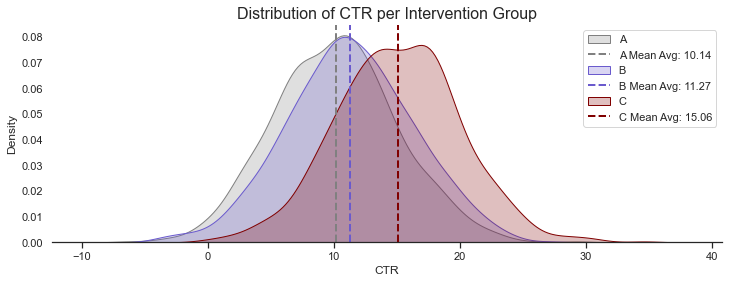

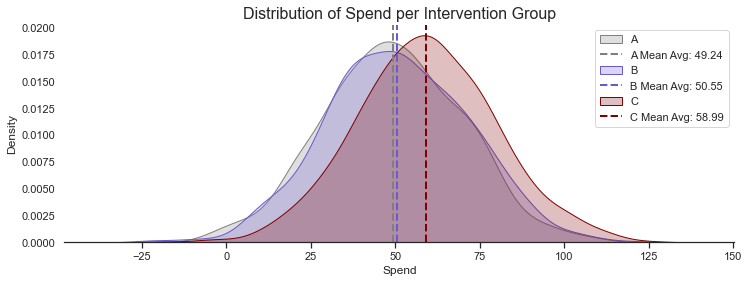

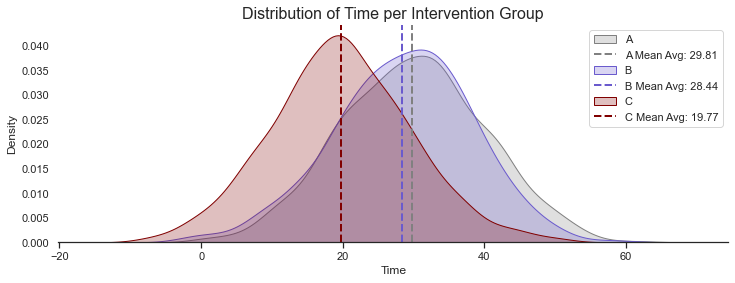

In [153]:
dependent_vars = ['CTR', 'Spend', 'Time']
intervention_groups = manova_data['Intervention'].unique()
colors = ['grey', 'slateblue', 'maroon', 'orange'] # Adjust as needed for the number of groups

for i, var in enumerate(dependent_vars):
    plt.figure(figsize=(12, 4))
    for j, group in enumerate(intervention_groups):
        subset = manova_data[manova_data['Intervention'] == group][var]
        sns.kdeplot(subset, label=group, fill=True, color=colors[j % len(colors)])
        mean_value = subset.mean()
        plt.axvline(mean_value, color=colors[j % len(colors)], linestyle='dashed', linewidth=2, label=f'{group} Mean Avg: {mean_value:.2f}')

    plt.title(f'Distribution of {var} per Intervention Group', fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tick_params(left=False, bottom=True, labelleft=True, labelbottom=True)
    plt.legend()
    plt.show()